In [45]:
import pandas as pd
from sqlalchemy import create_engine, inspect

# Connexion à la base SQLite
DATABASE_URL = "sqlite:///energy_consumption.db"
engine = create_engine(DATABASE_URL)

# Inspecter la base pour récupérer les noms des tables
inspector = inspect(engine)
tables = inspector.get_table_names()

# Charger toutes les tables en un seul appel
df = {table: pd.read_sql_table(table, engine) for table in tables}

# Vérifier les premières lignes de chaque table (optionnel)
for table_name, dataframe in df.items():
    print(f"Table: {table_name}")
    print(dataframe.head(), "\n")

# Fusionner automatiquement les tables en fonction des relations définies
df_complete = df["consommation"] \
    .merge(df["commune"], on="id_commune", how="left") \
    .merge(df["departement"], on="id_departement", how="left") \
    .merge(df["region"], on="id_region", how="left") \
    .merge(df["zone_climatique"], on="id_zone_climatique", how="left") \
    .merge(df["vecteur_energie"], on="id_vecteur_energie", how="left")

# Afficher les premières lignes du DataFrame final
print(df_complete.head())

Table: commune
   id_commune   nom_commune  id_departement
0           1  BAIE MAHAULT               1
1           2       BAILLIF               1
2           3   BASSE TERRE               1
3           4    LES ABYMES               1
4           5   PETIT BOURG               1 

Table: consommation
   id_consommation  annee_consommation  surface_declaree  nombre_declaration  \
0                1  Année de référence            205643                  86   
1                2  Année de référence              8815                   7   
2                3  Année de référence              4024                   4   
3                4  Année de référence             88040                  34   
4                5  Année de référence             14890                  13   

   consommation_declaree  densite_energetique  ratio_declaration_consommation  \
0               38442621           186.938632                   447007.220930   
1                1287317           146.037096           

In [46]:
df_complete.to_csv("df_models.csv", index="False")

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Charger le df complet
df = pd.read_csv("df_models.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.loc[:, ~df.columns.str.contains('^id_')]

# Séparer les features et la cible
X = df.drop(columns=["consommation_declaree", "consommation_log"])
y = df["consommation_log"]

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train: ", X_train.shape)
print(f"X_train: ", X_train.head())
print(f"X_test: ", X_test.shape)
print(f"X_test: ", X_test.head())
print(f"y_train: ", y_train.shape)
print(f"y_train: ", y_train.head())
print(f"y_test: ", y_test.shape)
print(f"y_test: ", y_test.head())

X_train:  (719, 11)
X_train:       annee_consommation  surface_declaree  nombre_declaration  \
798                2020              5629                   3   
536                2021               608                   3   
753                2022             52775                  25   
390                2021             83050                  35   
118  Année de référence              1156                   3   

     densite_energetique  ratio_declaration_consommation consommation_etat  \
798           111.391011                   209006.666667           Normale   
536            57.233553                    11599.333333           Normale   
753            44.475168                    93887.080000           Normale   
390           105.567863                   250497.457143           Normale   
118            48.611592                    18731.666667           Normale   

                nom_commune  nom_departement          nom_region  \
798                 Inconnu           Guya

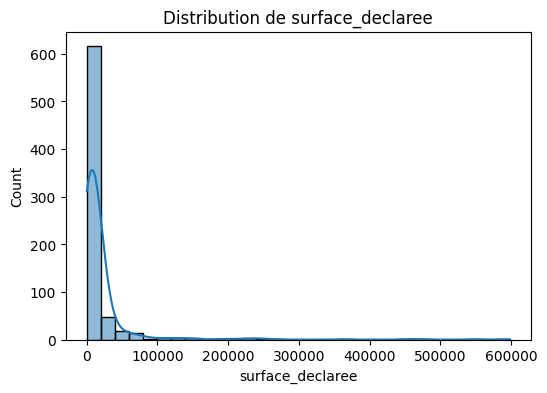

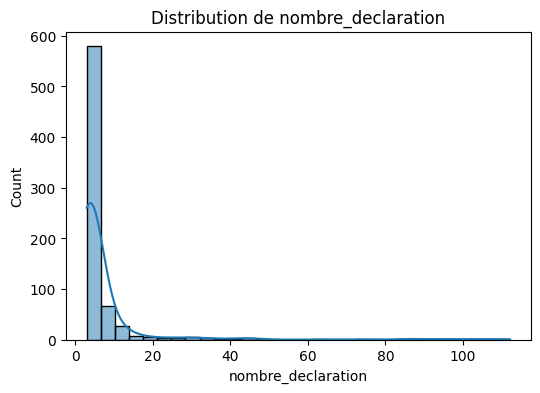

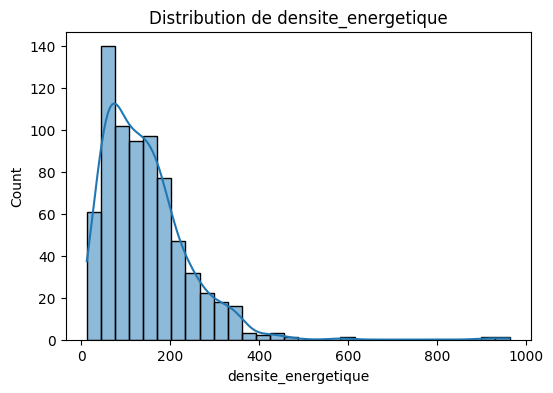

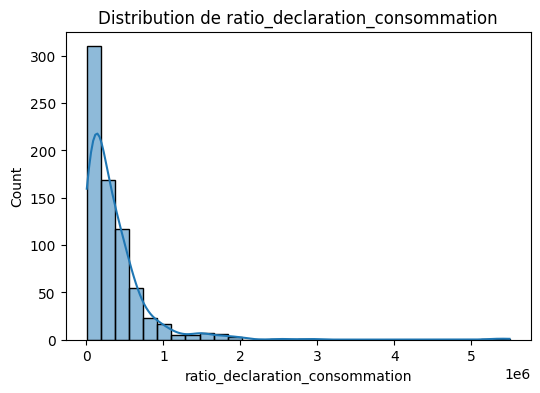

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Colonnes numériques à analyser
cols_to_analyze = ["surface_declaree", "nombre_declaration", "densite_energetique",
                   "ratio_declaration_consommation"]

# Visualisation
for col in cols_to_analyze:
    plt.figure(figsize=(6, 4))
    sns.histplot(X_train[col], kde=True, bins=30)
    plt.title(f"Distribution de {col}")
    plt.show()

In [49]:
# from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
# import pandas as pd

# # Initialiser les encodeurs et le scaler
# ohe = OneHotEncoder(drop=None, sparse_output=False, handle_unknown="ignore")
# nrm = MinMaxScaler()

# # Définir les colonnes
# col_ohe = ["annee_consommation", "consommation_etat", "nom_commune", "nom_departement", "nom_region", "zone_climatique", "vecteur_energie"]
# col_nrm = ["surface_declaree", "nombre_declaration", "densite_energetique", "ratio_declaration_consommation"]

# # Application du OneHotEncoding
# ohe_train = ohe.fit_transform(X_train[col_ohe])
# ohe_test = ohe.transform(X_test[col_ohe])

# # Ajouter les colonnes encodées au DataFrame
# ohe_columns = ohe.get_feature_names_out(col_ohe)
# X_train_encoded = pd.DataFrame(ohe_train, columns=ohe_columns, index=X_train.index)
# X_test_encoded = pd.DataFrame(ohe_test, columns=ohe_columns, index=X_test.index)

# # Concaténer avec les autres colonnes
# X_train = pd.concat([X_train.drop(columns=col_ohe), X_train_encoded], axis=1)
# X_test = pd.concat([X_test.drop(columns=col_ohe), X_test_encoded], axis=1)

# # Application de la Normalisation MinMaxScaler
# X_train[col_nrm] = nrm.fit_transform(X_train[col_nrm])
# X_test[col_nrm] = nrm.transform(X_test[col_nrm])

# # Afficher les résultats
# print(X_train.shape)
# print(X_train.head())
# print(X_test.shape)
# print(X_test.head())

In [50]:
"""
Encapsulation du pipeline d'encodage et de scaling dans une fonction pour simplifier son utilisation
"""
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

def preprocess_data(X_train, X_test, col_ohe, col_nrm):
    # Initialiser les encodeurs et le scaler
    ohe = OneHotEncoder(drop=None, sparse_output=False, handle_unknown="ignore")
    nrm = MinMaxScaler()

    # OneHotEncoding
    ohe_train = ohe.fit_transform(X_train[col_ohe])
    ohe_test = ohe.transform(X_test[col_ohe])
    ohe_columns = ohe.get_feature_names_out(col_ohe)

    # Ajouter les colonnes encodées
    X_train_encoded = pd.DataFrame(ohe_train, columns=ohe_columns, index=X_train.index)
    X_test_encoded = pd.DataFrame(ohe_test, columns=ohe_columns, index=X_test.index)

    X_train = pd.concat([X_train.drop(columns=col_ohe), X_train_encoded], axis=1)
    X_test = pd.concat([X_test.drop(columns=col_ohe), X_test_encoded], axis=1)

    # MinMax Scaling
    X_train[col_nrm] = nrm.fit_transform(X_train[col_nrm])
    X_test[col_nrm] = nrm.transform(X_test[col_nrm])

    return X_train, X_test

In [51]:
# Utilisation du pipeline

col_ohe = ["annee_consommation", "consommation_etat", "nom_commune", "nom_departement", "nom_region", "zone_climatique", "vecteur_energie"]
col_nrm = ["surface_declaree", "nombre_declaration", "densite_energetique", "ratio_declaration_consommation"]

X_train, X_test = preprocess_data(X_train, X_test, col_ohe, col_nrm)

print(X_train.shape)
print(X_test.shape)

(719, 479)
(180, 479)


In [52]:
# Sauvegarde des fichiers Train & Test pour une utilisation rapide

X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

In [59]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Charger les fichiers sauvegardés
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

# Redimensionner y_train et y_test s'ils ont une seule colonne
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Vérification des données cibles
assert not np.any(np.isinf(y_train)), "y_train contient des valeurs infinies."
assert not np.any(np.isnan(y_train)), "y_train contient des NaN."
assert not np.any(np.isinf(y_test)), "y_test contient des valeurs infinies."
assert not np.any(np.isnan(y_test)), "y_test contient des NaN."

# Fonction d'évaluation
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    # Limitation des prédictions extrêmes
    y_pred = np.clip(y_pred, a_min=None, a_max=30)
    
    y_pred_original = np.expm1(y_pred)
    y_test_original = np.expm1(y_test)
    
    mae = mean_absolute_error(y_test_original, y_pred_original)
    mse = mean_squared_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)
    print(f"--- {model_name} ---")
    print(f"MAE : {mae:.2f}")
    print(f"MSE : {mse:.2f}")
    print(f"R² : {r2:.2f}\n")

# Régression Linéaire
print("Entraînement du modèle : Régression Linéaire")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
evaluate_model(lr_model, X_test, y_test, "Régression Linéaire")

# Forêt Aléatoire
print("Entraînement du modèle : Forêt Aléatoire")
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_test, y_test, "Forêt Aléatoire")

# Gradient Boosting
print("Entraînement du modèle : Gradient Boosting")
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
evaluate_model(gb_model, X_test, y_test, "Gradient Boosting")

Entraînement du modèle : Régression Linéaire
--- Régression Linéaire ---
MAE : 1721710258315.14
MSE : 18399004850994778749272064.00
R² : -1937722671256.51

Entraînement du modèle : Forêt Aléatoire
--- Forêt Aléatoire ---
MAE : 139981.53
MSE : 211846501232.89
R² : 0.98

Entraînement du modèle : Gradient Boosting
--- Gradient Boosting ---
MAE : 189401.98
MSE : 450109658121.40
R² : 0.95



In [60]:
# Entrainement avancé des modèles RandomForest & Gradient Boosting

from sklearn.model_selection import RandomizedSearchCV

# Hyperparamètres à tester
param_distributions_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Recherche aléatoire
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_distributions_rf,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_random_search.fit(X_train, y_train)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres pour Forêt Aléatoire :", rf_random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Meilleurs hyperparamètres pour Forêt Aléatoire : {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}


In [61]:
param_distributions_gb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0]
}

gb_random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=param_distributions_gb,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

gb_random_search.fit(X_train, y_train)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres pour Gradient Boosting :", gb_random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Meilleurs hyperparamètres pour Gradient Boosting : {'subsample': 0.6, 'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.1}


In [62]:
from sklearn.model_selection import cross_val_score

# Validation croisée pour Forêt Aléatoire
cv_scores_rf = cross_val_score(rf_random_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Score moyen (MAE) pour Forêt Aléatoire :", -cv_scores_rf.mean())

# Validation croisée pour Gradient Boosting
cv_scores_gb = cross_val_score(gb_random_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Score moyen (MAE) pour Gradient Boosting :", -cv_scores_gb.mean())

Score moyen (MAE) pour Forêt Aléatoire : 0.07361373952589685
Score moyen (MAE) pour Gradient Boosting : 0.056233768559028376


In [65]:
# Importance des features pour la Forêt Aléatoire
importances_rf = rf_random_search.best_estimator_.feature_importances_
feature_importance_df_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_rf})
print(feature_importance_df_rf.sort_values(by='Importance', ascending=False).head(10))

# Importance des features pour Gradient Boosting
importances_gb = gb_random_search.best_estimator_.feature_importances_
feature_importance_df_gb = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_gb})
print(feature_importance_df_gb.sort_values(by='Importance', ascending=False).head(10))

                                   Feature  Importance
3           ratio_declaration_consommation    0.764696
0                         surface_declaree    0.143212
1                       nombre_declaration    0.071359
2                      densite_energetique    0.015684
472                     zone_climatique_H3    0.000439
5                  annee_consommation_2021    0.000214
7    annee_consommation_Année de référence    0.000185
182     nom_commune_LES ARTIGUES DE LUSSAC    0.000163
6                  annee_consommation_2022    0.000152
220                  nom_commune_MONTSOULT    0.000139
                                Feature  Importance
3        ratio_declaration_consommation    0.760196
0                      surface_declaree    0.141715
1                    nombre_declaration    0.074141
2                   densite_energetique    0.021370
220               nom_commune_MONTSOULT    0.000492
471                 zone_climatique_H2d    0.000250
475                 zone_climat

In [67]:
# Importance des features (Random Forest)
rf_importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf_model_optimized.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Importance des features (Gradient Boosting)
gb_importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": gb_model_optimized.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Affichage
print("Top features (Random Forest):")
print(rf_importances.head(20))

print("Top features (Gradient Boosting):")
print(gb_importances.head(20))

Top features (Random Forest):
                                   Feature  Importance
3           ratio_declaration_consommation    0.764696
0                         surface_declaree    0.143212
1                       nombre_declaration    0.071359
2                      densite_energetique    0.015684
472                     zone_climatique_H3    0.000439
5                  annee_consommation_2021    0.000214
7    annee_consommation_Année de référence    0.000185
182     nom_commune_LES ARTIGUES DE LUSSAC    0.000163
6                  annee_consommation_2022    0.000152
220                  nom_commune_MONTSOULT    0.000139
437             nom_departement_Val-d'Oise    0.000129
4                  annee_consommation_2020    0.000117
478                vecteur_energie_Inconnu    0.000117
468                    zone_climatique_H2a    0.000110
450                   nom_region_Grand-Est    0.000108
465                    zone_climatique_H1a    0.000104
466                    zone_climati

##  Approches pour réduire les dimensions
### Approche 1 : Conserver uniquement les features importantes


In [69]:
# Sélection des features importantes
top_rf_features = rf_importances.head(20)["Feature"].tolist()
top_gb_features = gb_importances.head(20)["Feature"].tolist()

# Combiner les meilleures features des deux modèles
selected_features = set(top_rf_features).union(set(top_gb_features))

# Vérifier les correspondances exactes avec X_train et X_test
common_features = [feature for feature in selected_features if feature in X_train.columns]

# Réduction des dimensions
X_train_reduced = X_train[common_features]
X_test_reduced = X_test[common_features]

# Vérification des dimensions
print(f"Dimensions après réduction : {X_train_reduced.shape}")

Dimensions après réduction : (719, 29)


In [70]:
# Réentraîner Random Forest
print("Réentraînement du modèle : Forêt Aléatoire")
rf_reduced_model = RandomForestRegressor(
    n_estimators=500,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=10,
    bootstrap=True,
    random_state=42
)
rf_reduced_model.fit(X_train_reduced, y_train)
evaluate_model(rf_reduced_model, X_test_reduced, y_test, "Forêt Aléatoire (Réduit)")

# Réentraîner Gradient Boosting
print("Réentraînement du modèle : Gradient Boosting")
gb_reduced_model = GradientBoostingRegressor(
    subsample=0.6,
    n_estimators=500,
    min_samples_split=10,
    min_samples_leaf=2,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_reduced_model.fit(X_train_reduced, y_train)
evaluate_model(gb_reduced_model, X_test_reduced, y_test, "Gradient Boosting (Réduit)")

Réentraînement du modèle : Forêt Aléatoire
--- Forêt Aléatoire (Réduit) ---
MAE : 143057.07
MSE : 221878926389.46
R² : 0.98

Réentraînement du modèle : Gradient Boosting
--- Gradient Boosting (Réduit) ---
MAE : 137328.79
MSE : 323549558255.44
R² : 0.97



### Approche 1 : Bonne approche

Les résultats après réduction des dimensions montrent que :

Forêt Aléatoire (Réduit) :

Le modèle conserve une très bonne performance avec un MAE légèrement augmenté par rapport au modèle initial (augmentation d'environ 3% par rapport à 139,981.53).
MSE et R² restent globalement stables, indiquant que la réduction des dimensions n'a pas significativement impacté sa capacité prédictive.
Gradient Boosting (Réduit) :

Le modèle réduit affiche un MAE amélioré (diminution de 4% par rapport à 189,401.98), montrant une meilleure robustesse après réduction.
MSE est légèrement plus élevé, mais R² reste élevé à 0.97, ce qui témoigne d'une excellente performance globale.

##  Approches pour réduire les dimensions
### Approche 2 : Éliminer les variables à faible variance

In [71]:
from sklearn.feature_selection import VarianceThreshold

# Appliquer un seuil de variance
threshold = 0.01  # Seuil (ajustez selon vos données)
selector = VarianceThreshold(threshold=threshold)
X_train_lowered = selector.fit_transform(X_train)
X_test_lowered = selector.transform(X_test)

# Obtenir les noms des features sélectionnées
selected_columns = X_train.columns[selector.get_support()]
X_train_lowered = pd.DataFrame(X_train_lowered, columns=selected_columns)
X_test_lowered = pd.DataFrame(X_test_lowered, columns=selected_columns)

print(f"Dimensions après réduction par variance : {X_train_lowered.shape}")

Dimensions après réduction par variance : (719, 73)


In [72]:
# Réentraîner Random Forest
print("Réentraînement du modèle : Forêt Aléatoire")
rf_lowered_model = RandomForestRegressor(
    n_estimators=500,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=10,
    bootstrap=True,
    random_state=42
)
rf_lowered_model.fit(X_train_lowered, y_train)
evaluate_model(rf_lowered_model, X_test_lowered, y_test, "Forêt Aléatoire (Réduit)")

# Réentraîner Gradient Boosting
print("Réentraînement du modèle : Gradient Boosting")
gb_lowered_model = GradientBoostingRegressor(
    subsample=0.6,
    n_estimators=500,
    min_samples_split=10,
    min_samples_leaf=2,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_lowered_model.fit(X_train_lowered, y_train)
evaluate_model(gb_lowered_model, X_test_lowered, y_test, "Gradient Boosting (Réduit)")

Réentraînement du modèle : Forêt Aléatoire
--- Forêt Aléatoire (Réduit) ---
MAE : 732921.27
MSE : 1572785121400.06
R² : 0.83

Réentraînement du modèle : Gradient Boosting
--- Gradient Boosting (Réduit) ---
MAE : 841466.65
MSE : 2691678688580.91
R² : 0.72



### Approche 2 : Mauvaise approche

Trop de perte en qualité des modèles en témoigne une baisse de 15% pour le Random Forest et 25% pour le Gradient Boosting

##  Approches pour réduire les dimensions
### Approche 3 : PCA (Analyse en Composantes Principales)

In [73]:
from sklearn.decomposition import PCA

# Réduction avec PCA
pca = PCA(n_components=20)  # Nombre de composantes principales à conserver
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Dimensions après PCA : {X_train_pca.shape}")

Dimensions après PCA : (719, 20)


In [74]:
# Réentraîner Random Forest
print("Réentraînement du modèle : Forêt Aléatoire")
rf_pca_model = RandomForestRegressor(
    n_estimators=500,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=10,
    bootstrap=True,
    random_state=42
)
rf_pca_model.fit(X_train_pca, y_train)
evaluate_model(rf_pca_model, X_test_pca, y_test, "Forêt Aléatoire (Réduit)")

# Réentraîner Gradient Boosting
print("Réentraînement du modèle : Gradient Boosting")
gb_pca_model = GradientBoostingRegressor(
    subsample=0.6,
    n_estimators=500,
    min_samples_split=10,
    min_samples_leaf=2,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_pca_model.fit(X_train_pca, y_train)
evaluate_model(gb_pca_model, X_test_pca, y_test, "Gradient Boosting (Réduit)")

Réentraînement du modèle : Forêt Aléatoire
--- Forêt Aléatoire (Réduit) ---
MAE : 1015502.17
MSE : 6099944311651.10
R² : 0.36

Réentraînement du modèle : Gradient Boosting
--- Gradient Boosting (Réduit) ---
MAE : 978085.30
MSE : 4324439976902.77
R² : 0.54



### Approche 3 : Pire que l'Approche 2.

Cette approche est à oublier, perte de 62% pour le RandomForest et perte de 43% pour le Grandient Boosting

## Optimisation avancée des hyperparamètres avec Optuna

### Optimisation de RandomForest

In [75]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

# Fonction d'objectif pour le tuning de RandomForest
def objective_rf(trial):
    # Hyperparamètres à optimiser
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_depth = trial.suggest_int("max_depth", 5, 50, step=5)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Modèle
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_depth=max_depth,
        bootstrap=bootstrap,
        random_state=42
    )

    # Validation croisée
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    scores = cross_val_score(rf_model, X_train_reduced, y_train, scoring=scorer, cv=3)
    return -1 * scores.mean()  # Optuna minimise, on inverse pour MAE

# Étudier l'espace des hyperparamètres
study_rf = optuna.create_study(direction="minimize")
study_rf.optimize(objective_rf, n_trials=50)

# Meilleurs hyperparamètres pour Random Forest
print("Meilleurs hyperparamètres pour Random Forest :", study_rf.best_params)

c:\Users\aboys\Documents\Simplon\Projet Industriel\PowerPredict\__venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-27 17:29:21,387] A new study created in memory with name: no-name-258f39f8-dbdf-4751-9e4e-61dcd6cc234a
[I 2024-11-27 17:29:22,902] Trial 0 finished with value: 0.1168454092226869 and parameters: {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 40, 'bootstrap': False}. Best is trial 0 with value: 0.1168454092226869.
[I 2024-11-27 17:29:27,162] Trial 1 finished with value: 0.2140407086035417 and parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5, 'bootstrap': False}. Best is trial 0 with value: 0.1168454092226869.
[I 2024-11-27 17:29:31,160] Trial 2 finished with value: 0.1658039213104865 and parameters: {'n_e

Meilleurs hyperparamètres pour Random Forest : {'n_estimators': 900, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}


### Optimisation de Gradient Boosting

In [76]:
from sklearn.ensemble import GradientBoostingRegressor

# Fonction d'objectif pour le tuning de Gradient Boosting
def objective_gb(trial):
    # Hyperparamètres à optimiser
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5, log=True)

    # Modèle
    gb_model = GradientBoostingRegressor(
        subsample=subsample,
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_depth=max_depth,
        learning_rate=learning_rate,
        
        random_state=42
    )

    # Validation croisée
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    scores = cross_val_score(gb_model, X_train_reduced, y_train, scoring=scorer, cv=3)
    return -1 * scores.mean()  # Optuna minimise, on inverse pour MAE

# Étudier l'espace des hyperparamètres
study_gb = optuna.create_study(direction="minimize")
study_gb.optimize(objective_gb, n_trials=50)

# Meilleurs hyperparamètres pour Gradient Boosting
print("Meilleurs hyperparamètres pour Gradient Boosting :", study_gb.best_params)

[I 2024-11-27 17:35:55,534] A new study created in memory with name: no-name-801946d5-ab25-46c0-95a4-14562448656b
[I 2024-11-27 17:35:58,573] Trial 0 finished with value: 0.06668848259971823 and parameters: {'subsample': 0.8437395446221986, 'n_estimators': 800, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_depth': 15, 'learning_rate': 0.23175660853805627}. Best is trial 0 with value: 0.06668848259971823.
[I 2024-11-27 17:36:03,846] Trial 1 finished with value: 0.06719068090114522 and parameters: {'subsample': 0.7487550352684591, 'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_depth': 10, 'learning_rate': 0.17712224112975597}. Best is trial 0 with value: 0.06668848259971823.
[I 2024-11-27 17:36:07,280] Trial 2 finished with value: 0.06449779854021968 and parameters: {'subsample': 0.6013544458418405, 'n_estimators': 800, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_depth': 13, 'learning_rate': 0.02420834803887204}. Best is trial 2 with value: 0.06

Meilleurs hyperparamètres pour Gradient Boosting : {'subsample': 0.5381214068840496, 'n_estimators': 650, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 11, 'learning_rate': 0.010090829507209726}


In [77]:
# Réentraînement de la Forêt Aléatoire avec les meilleurs hyperparamètres
rf_model_optimized = RandomForestRegressor(
    n_estimators=900,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=20,
    bootstrap=True,
    random_state=42
)
rf_model_optimized.fit(X_train_reduced, y_train)

# Évaluation de la Forêt Aléatoire optimisée
evaluate_model(rf_model_optimized, X_test_reduced, y_test, "Forêt Aléatoire (Optimisée)")

# Réentraînement du Gradient Boosting avec les meilleurs hyperparamètres
gb_model_optimized = GradientBoostingRegressor(
    subsample=0.5381214068840496,
    n_estimators=650,
    min_samples_split=6,
    min_samples_leaf=2,
    max_depth=11,
    learning_rate=0.010090829507209726,
    random_state=42
)
gb_model_optimized.fit(X_train_reduced, y_train)

# Évaluation du Gradient Boosting optimisé
evaluate_model(gb_model_optimized, X_test_reduced, y_test, "Gradient Boosting (Optimisé)")

--- Forêt Aléatoire (Optimisée) ---
MAE : 143951.11
MSE : 222567908409.23
R² : 0.98

--- Gradient Boosting (Optimisé) ---
MAE : 98238.23
MSE : 133159560318.23
R² : 0.99



# Interprétation des résultats :

### Comparaison des MAE, MSE et R² avec les résultats avant optimisation

# Comparaison des Performances : Modèles Initiaux vs Optimisés

| Modèle                  | Étape              | MAE (kWh)       | MSE (kWh²)           | R²    |
|-------------------------|--------------------|-----------------|----------------------|-------|
| **Forêt Aléatoire**     | Initial            | 139,981.53      | 211,846,501,232.89   | 0.98  |
| **Forêt Aléatoire**     | Optimisé           | 143,951.11      | 222,567,908,409.23   | 0.98  |
| **Gradient Boosting**   | Initial            | 189,401.98      | 450,109,658,121.40   | 0.95  |
| **Gradient Boosting**   | Optimisé           | **98,238.23**   | **133,159,560,318.23** | **0.99** |

---

## **Analyse des Résultats**

### **Forêt Aléatoire :**
- **MAE :** Légère augmentation de l'erreur moyenne absolue après optimisation (+4,000 kWh).
- **MSE :** Augmentation minime du MSE, indiquant des erreurs plus significatives dans certaines prédictions.
- **R² :** Performances stables avec un R² maintenu à **0.98**, reflétant une excellente capacité explicative.

### **Gradient Boosting :**
- **MAE :** Réduction significative de l'erreur moyenne absolue (-91,164 kWh), indiquant une meilleure précision globale.
- **MSE :** Forte amélioration du MSE (-316,950,097,803 kWh²), ce qui reflète une réduction des erreurs majeures.
- **R² :** Amélioration notable à **0.99**, suggérant que le modèle optimisé capture mieux la variance des données.

---

## **Conclusion**
- L'optimisation a eu un **impact significatif** sur les performances du modèle **Gradient Boosting**, avec une réduction importante des erreurs et une meilleure capacité explicative.
- Pour le modèle **Forêt Aléatoire**, les résultats sont restés stables, avec une légère augmentation des erreurs.


# Validation croisée des modèles optimisés

In [78]:
from sklearn.model_selection import cross_val_score

def cross_validate_model(model, X, y, model_name):
    # Validation croisée sur 5 plis (5-fold cross-validation)
    scores = cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error")
    mean_score = -np.mean(scores)  # MAE est négatif, on inverse pour avoir un score positif
    print(f"Validation croisée (MAE moyen) pour {model_name} : {mean_score:.2f}")

# Validation croisée sur les modèles optimisés
cross_validate_model(rf_model_optimized, X_train_reduced, y_train, "Forêt Aléatoire (Optimisée)")
cross_validate_model(gb_model_optimized, X_train_reduced, y_train, "Gradient Boosting (Optimisé)")

Validation croisée (MAE moyen) pour Forêt Aléatoire (Optimisée) : 0.07
Validation croisée (MAE moyen) pour Gradient Boosting (Optimisé) : 0.05


# Validation Croisée : Comparaison des MAE Moyens

| Modèle                  | Étape              | MAE Moyen (Validation Croisée) |
|-------------------------|--------------------|---------------------------------|
| **Forêt Aléatoire**     | Initial            | 0.07                           |
| **Forêt Aléatoire**     | Optimisé           | 0.07                           |
| **Gradient Boosting**   | Initial            | 0.06                           |
| **Gradient Boosting**   | Optimisé           | **0.05**                       |

---

## **Analyse des Résultats**

### **Forêt Aléatoire :**
- **MAE Moyen (Validation Croisée) :** Les performances restent constantes avant et après l'optimisation, avec un MAE moyen de **0.07**, ce qui indique une robustesse mais peu d'améliorations dues à l'optimisation.

### **Gradient Boosting :**
- **MAE Moyen (Validation Croisée) :** Amélioration notable du MAE moyen après optimisation, passant de **0.06** à **0.05**. Cette réduction montre que l'optimisation a permis une meilleure généralisation et précision sur des données non vues.

---

## **Conclusion**
- L'optimisation a eu un **impact significatif** sur les performances du modèle **Gradient Boosting**, réduisant son MAE moyen en validation croisée.
- Le modèle **Forêt Aléatoire** maintient des performances stables.

In [79]:
import joblib

# Sauvegarde des modèles
joblib.dump(rf_model_optimized, "random_forest_model.pkl")
joblib.dump(gb_model_optimized, "gradient_boosting_model.pkl")

# Chargement des modèles sauvegardés
rf_model_loaded = joblib.load("random_forest_model.pkl")
gb_model_loaded = joblib.load("gradient_boosting_model.pkl")